In [23]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import gtts as gt 
import os  

In [2]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
# load features from pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [4]:
with open('tamil_captions.txt', 'r', encoding='utf8') as f:
    next(f)
    captions_doc = f.read()

In [5]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/26845 [00:00<?, ?it/s]

In [6]:
len(mapping)

5099

In [7]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            #print(caption)
            captions[i] = caption

In [8]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['ஒரு பெண் ஒரு மர கட்டிடத்திற்குள் செல்கிறாள்.',
 'ஒரு சிறிய பெண் ஒரு மர விளையாட்டு இல்லத்தில் ஏறுகிறாள்.',
 'ஒரு சிறுமி தன் விளையாட்டு விடுதிக்கு படிக்கட்டுகளில் ஏறுகிறாள்.',
 'இளஞ்சிவப்பு நிற உடையில் ஒரு சிறுமி மர அறைக்குள் செல்கிறாள்.']

In [9]:
# preprocess the text
clean(mapping)

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:
len(all_captions)

26845

In [12]:
all_captions[:10]

['startseq ஒரு பெண் ஒரு மர கட்டிடத்திற்குள் செல்கிறாள். endseq',
 'startseq ஒரு சிறிய பெண் ஒரு மர விளையாட்டு இல்லத்தில் ஏறுகிறாள். endseq',
 'startseq ஒரு சிறுமி தன் விளையாட்டு விடுதிக்கு படிக்கட்டுகளில் ஏறுகிறாள். endseq',
 'startseq இளஞ்சிவப்பு நிற உடையில் ஒரு சிறுமி மர அறைக்குள் செல்கிறாள். endseq',
 'startseq ஒரு கருப்பு நாயும் புள்ளி நாயும் சண்டையிடுகின்றன endseq',
 'startseq ஒரு கருப்பு நாயும் மூன்று நிற நாயும் சாலையில் ஒன்றோடு ஒன்று விளையாடிக் கொண்டிருந்தன. endseq',
 'startseq ஒரு கருப்பு நாயும் பழுப்பு நிறப் புள்ளிகளுடன் ஒரு வெள்ளை நாயும் தெருவில் ஒருவரையொருவர் பார்த்துக் கொண்டிருக்கின்றன. endseq',
 'startseq வெவ்வேறு இனத்தைச் சேர்ந்த இரண்டு நாய்கள் சாலையில் ஒன்றையொன்று பார்த்துக் கொள்கின்றன. endseq',
 'startseq நடைபாதையில் இரண்டு நாய்கள் ஒன்றையொன்று நோக்கி நகர்கின்றன. endseq',
 'startseq வர்ணம் பூசப்பட்ட ஒரு சிறுமி வர்ணம் பூசப்பட்ட வானவில்லின் முன் ஒரு பாத்திரத்தில் கைகளை வைத்து அமர்ந்திருக்கிறாள். endseq']

In [13]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
vocab_size

14035

In [15]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

29

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [17]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [30]:
def text_to_speech(caption): 
    caption = caption.replace("startseq","")
    caption = caption.replace("endseq","")
    TamilText=caption
    tts = gt.gTTS(text=TamilText, lang='ta')
    tts.save("Tamil-Audio.mp3")
    os.system("Tamil-Audio.mp3")

In [31]:
#!pip install pydot

In [32]:
#!pip install graphviz

In [33]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [34]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [37]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [38]:
from tensorflow import keras
model = keras.models.load_model('best_model.h5', compile=False)
model.compile()

---------------------Actual---------------------
startseq ஒரு பழுப்பு நிற நாய் புல்லில் பல வண்ண பொம்மைகளை எடுத்துச் செல்கிறது. endseq
startseq ஒரு பழுப்பு நிற நாய் அதன் பொம்மையை வாயில் வைத்துக்கொண்டு முற்றத்தில் ஓடுகிறது. endseq
startseq பொம்மையுடன் ஒரு நாய் புல் வழியாக ஓடுகிறது. endseq
startseq ஒரு கோல்டன் ரெட்ரீவர் நாய் பொம்மையை சுமந்து கொண்டு புல் வழியாக ஓடுகிறது. endseq
startseq நாய் பொம்மையை வாயில் வைத்துக்கொண்டு ஓடுகிறது. endseq
--------------------Predicted--------------------
startseq ஒரு பழுப்பு நிற நாய் அதன் வாயில் பொம்மையை வைத்துக்கொண்டு ஓடுகிறது endseq


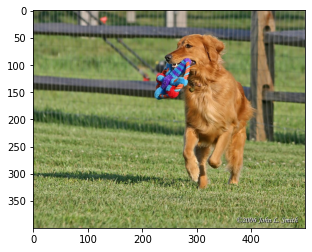

In [39]:
generate_caption("316833109_6500b526dc.jpg")

---------------------Actual---------------------
startseq சிவப்பு ஸ்லைடில் ஒரு குழந்தை. endseq
startseq ஒரு சிறுவன் விளையாட்டு மைதானத்தில் ஒரு ஸ்லைடில் அமர்ந்திருக்கிறான். endseq
startseq ஒரு சிறிய பையன் ஒரு பிரகாசமான சிவப்பு கார்க்ஸ்க்ரூ ஸ்லைடில் கீழே சரிந்தான். endseq
startseq ஒரு சிறிய பையன் ஒரு சிவப்பு ஸ்லைடில் கீழே சரிந்தான். endseq
startseq நீல நிற உடை அணிந்த ஒரு இளம் பையன் சிவப்பு ஸ்லைடில் சறுக்குகிறான். endseq
--------------------Predicted--------------------
startseq ஒரு மனிதன் ஒரு ஸ்லைடில் சறுக்குகிறான் endseq


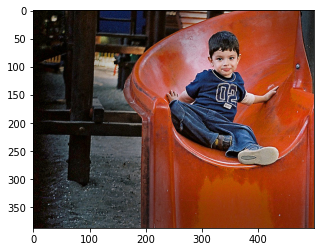

In [40]:
generate_caption("1490670858_e122df2560.jpg")

---------------------Actual---------------------
startseq ஒரு மனிதன் மல்யுத்த வளையத்தில் வெள்ளை முகம் மற்றும் நீண்ட கூந்தலுடன் மற்றொரு மனிதன் மீது குதிக்கிறான். endseq
startseq ஒரு மனிதன் வளையத்தில் மல்யுத்த வீரரின் மீது மல்யுத்த நகர்வை செய்கிறான். endseq
startseq ஒரு தொழில்முறை மல்யுத்த வீரர் மற்றொரு மல்யுத்த வீரர் மீது பறக்கும் பாய்ச்சலை எடுக்கிறார். endseq
startseq ஒரு மல்யுத்த வீரர் ஒரு வளையத்தில் படுத்திருந்த மற்றொரு மல்யுத்த வீரர் மீது விழுகிறார். endseq
startseq மல்யுத்த வீரர் வீழ்வதை மக்கள் பார்த்துக்கொண்டிருக்கிறார்கள் endseq
--------------------Predicted--------------------
startseq ஒரு மல்யுத்த வீரர் ஒரு மல்யுத்த வளையத்தில் இன்னொருவனை சண்டையிடுகிறார்கள் endseq


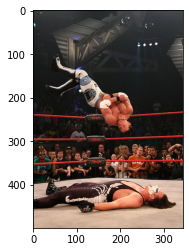

In [41]:
generate_caption("3018847610_0bf4d7e43d.jpg")

In [42]:
image_path = 'dogs.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
caption = predict_caption(model, feature, tokenizer, max_length)
caption

'startseq ஒரு பழுப்பு நிற நாய் அதன் வாயில் ஒரு குச்சியை வைத்திருக்கிறது endseq'

In [78]:
text_to_speech(caption)

In [79]:
image_path = 'football.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
caption = predict_caption(model, feature, tokenizer, max_length)
caption

'startseq ஒரு சிறுவன் பந்தைத் பந்தை உதைக்கப் போகிறார் endseq'

In [80]:
text_to_speech(caption)

In [95]:
image_path = 'tree.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
caption = predict_caption(model, feature, tokenizer, max_length)
caption

'startseq ஒரு காட்டுப் பாதையில் ஒரு நடைபயணி காட்டில் நடந்து செல்கிறார்கள் endseq'

In [96]:
text_to_speech(caption)